In this challenge we're tasked with the following question:

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevendayperiod, can you identify which factors can be used to predict future user adoption?

### Import and Explore Data

In [1]:
#import packages
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from  datetime  import timedelta


In [2]:
#read user data into dataframe
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [3]:
#explore user data
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
#read engagement data into dataframe
engagement = pd.read_csv('takehome_user_engagement.csv')

In [6]:
#explore engagment data
print(engagement.head())
print('')
print(engagement.info())

            time_stamp  user_id  visited
0  2014-04-22 03:53:30        1        1
1  2013-11-15 03:45:04        2        1
2  2013-11-29 03:45:04        2        1
3  2013-12-09 03:45:04        2        1
4  2013-12-25 03:45:04        2        1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


In [7]:
#set the time_stamp to datetime and the set it as the index
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)
engagement = engagement.set_index('time_stamp', drop= True)

### Label adopted users
Adopted users are defined as having logged in on three separate days within any given seven day period

In [8]:
def adopted(x):    
    """ Look at each user and determine whether or not they have logged in at least 3 times in 7 day period """
    user_visits = engagement.loc[engagement['user_id'] == x] #look at activity for this user only
    user_visits = user_visits.resample('D').mean().dropna() #resample by day, drop days with no activity
    label = 0
    for i in range(len(user_visits)-2): #loop over active days till the second to last day
        if user_visits.index[i + 2] - user_visits.index[i] <= timedelta(days=7): # is difference between 1st and 3rd day < 7?
            label = 1
            break
        else:
            label = 0
    return label

In [9]:
#apply to user df to label users as adopted=true 
users['adopted_user'] = users['object_id'].apply(adopted)

### How does the adoption count break down for the following features:
creation source, organization, users on the mailing list, users receiveng the marketing drip emails, and referring users

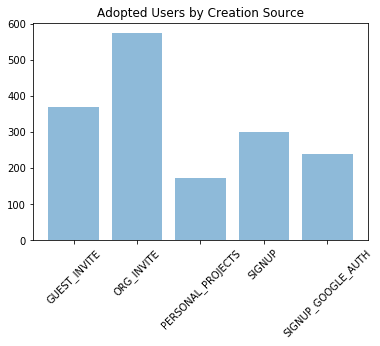

In [10]:
#breakdown the total number of adopted users by creation source
source = users.groupby('creation_source').sum()

plt.bar(source.index, source.adopted_user, alpha=.5)
plt.title('Adopted Users by Creation Source')
plt.xticks(rotation=45)
plt.show()

opted_in_to_mailing_list
0    1227
1     429
Name: adopted_user, dtype: int64


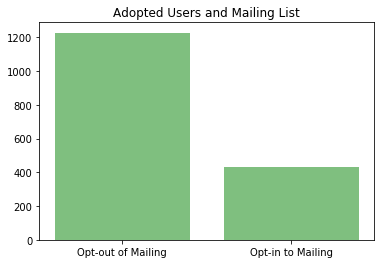

In [11]:
#breakdown the total number of adopted users by whether or not they opted in to mailing list
mailing = users.groupby('opted_in_to_mailing_list').sum()
print(mailing.adopted_user)

plt.bar(mailing.index, mailing.adopted_user, color='green', alpha=.5)
plt.title('Adopted Users and Mailing List')
plt.xticks(mailing.index, ['Opt-out of Mailing', 'Opt-in to Mailing'])
plt.show()

enabled_for_marketing_drip
0    1399
1     257
Name: adopted_user, dtype: int64


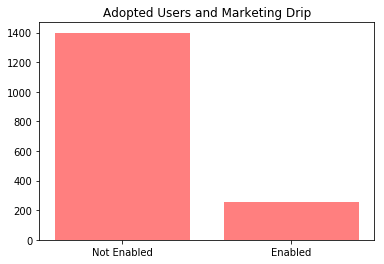

In [12]:
#breakdown the total number of adopted by whether or not they were enabled for marketing drip
drip = users.groupby('enabled_for_marketing_drip').sum()
print(drip.adopted_user)

plt.bar(drip.index, drip.adopted_user, color='red', alpha=.5)
plt.title('Adopted Users and Marketing Drip')
plt.xticks(mailing.index, ['Not Enabled', 'Enabled'])
plt.show()

In [13]:
#find the total number of adopted users by organization
org = users.groupby('org_id').sum()

print('Top 10 Organizations: ', org.adopted_user.sort_values(ascending=False).head(10))
print('')
print('Bottom 10 Organizations: ', org.adopted_user.sort_values(ascending=False).tail(10))

Top 10 Organizations:  org_id
4     17
1     16
7     16
2     15
13    14
3     14
9     14
0     12
5     12
62    12
Name: adopted_user, dtype: int64

Bottom 10 Organizations:  org_id
346    0
329    0
310    0
307    0
299    0
151    0
279    0
183    0
242    0
416    0
Name: adopted_user, dtype: int64


In [14]:
#find the total number of adopted users by the referring user

invite = users.groupby('invited_by_user_id').sum()

print('Top 10 Referring Users: ', invite.adopted_user.sort_values(ascending=False).head(10))
print('')
print('Bottom 10 Referring Users: ', invite.adopted_user.sort_values(ascending=False).tail(10))

Top 10 Referring Users:  invited_by_user_id
2354.0     4
10628.0    4
11267.0    3
9726.0     3
7882.0     3
2776.0     3
5910.0     3
2771.0     3
7107.0     3
9510.0     3
Name: adopted_user, dtype: int64

Bottom 10 Referring Users:  invited_by_user_id
7196.0    0
7202.0    0
7205.0    0
7211.0    0
7216.0    0
7230.0    0
7245.0    0
7248.0    0
7266.0    0
3.0       0
Name: adopted_user, dtype: int64


### Which features are most important in determining user adoption?

In [15]:
#check to see which features have an null values
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted_user                  12000 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


In [16]:
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)

In [17]:
#next we need to define predictor and target variables
X1 = users[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'] ]
y = users['adopted_user']

In [18]:
#create dummy variables for categorical features
X = pd.get_dummies(X1)

In [19]:
#Because this is a binary classification problem we can start by looking at logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=15)

parameters = {'C': [0.001, 0.1, 1, 10, 100]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid=parameters)
logreg_cv.fit(X_train, y_train)
print(logreg_cv.best_params_)

y_pred = logreg_cv.predict(X_test)
print(logreg_cv.score(X_test, y_test))

{'C': 0.001}
0.8608333333333333


In [20]:
#check the coefficents of the logistic regression model
logreg = LogisticRegression(C=.001)
logreg.fit(X_train, y_train)
logreg.coef_

array([[-1.30542516e-01, -7.50609196e-02, -2.64371292e-03,
        -9.65865705e-05, -1.38830903e-02, -9.22023121e-02,
        -2.35163868e-01, -1.62092577e-01, -9.54721548e-02]])

In [21]:
#we can use lasso regularization to see which features are most important in predicting the target variable

from sklearn.linear_model import Lasso

lasso = Lasso()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=15)

lasso_coef = lasso.fit(X_train,y_train).coef_

lasso_coef

array([ 0.00000000e+00,  0.00000000e+00,  1.45356026e-04,  1.79502664e-06,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [22]:
#look at the columns that match up with the lasso coefficents
X.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [23]:
#test the model only using the features lasso regularization kept
Xr = users[['org_id', 'invited_by_user_id'] ]
X_train, X_test, y_train, y_test = train_test_split(Xr, y, test_size=.2, random_state=15)

In [24]:
parameters = {'C': [0.001, 0.1, 1, 10, 100]}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid=parameters)
logreg_cv.fit(X_train, y_train)
print(logreg_cv.best_params_)

y_pred = logreg_cv.predict(X_test)
print(logreg_cv.score(X_test, y_test))

{'C': 0.001}
0.8608333333333333


### Features used for predicting future adoption

You will notice that the model preformed just as well using all the features as it did while only using the org_id and invited_by_user_id variables. The org_id and invited_by_user variables are clearly the main features behind predicting user adoption. 

Lasso regularization performs both regularization and variable selection to ehance prediction accuracy. It minimizes the coefficents to prevent overfitting, but does this without losing important properties in the data. The Lasso regularization did not minimize org_id and invited_by_user_id as these were the main properties attributed to predicting user adoption. 

This makes sense looking back at how the number of adopted users broke down for different features. Opting into the mailing list or enabling the marketing drip, for example, actually were associated with fewer adopted users than if no action was being taken by the company. It was clear these features did not have a high influence on user adoption.

